In [3]:
import warnings
warnings.filterwarnings("ignore")

import time
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import pytorch_lightning
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from PIL import Image
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight

from src.utils.utils import training, testing, EarlyStopping, get_y_true_preds
from src.utils.LungDataset import LungSet
from src.modeling.LungNetwork import LungNet

import torch
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
seed=2024
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

prefix="7C"

Number of available GPUs: 2


In [4]:
train_path = f"dataset/dataframes/df_train_{prefix}.csv"
test_path = f"dataset/dataframes/df_test_{prefix}.csv"

dtrain= pd.read_csv(train_path).sample(frac = 1)
dtest = pd.read_csv(test_path).sample(frac = 1)
df=pd.concat([dtrain,dtest], ignore_index=True)
X_train, y_train=dtrain.drop('label',axis=1), dtrain['label']

#oversample train data
X_ros, y_ros = RandomOverSampler().fit_resample(X_train, y_train)
Y_ros = y_ros.to_frame(name=None)

X_train = X_ros
X_train['label'] = Y_ros

tranform = tt.Compose([tt.ToTensor()])

images_path = "dataset/normalized_data"
train_set = LungSet(X_train, images_path, tranform)
test_set = LungSet(dtest, images_path, tranform)

BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
baseline_path = "src/modeling/tenpercent_resnet18.ckpt"
num_classes = 7

model = LungNet(baseline_path, num_classes)
model=nn.DataParallel(model, device_ids=[0])
weights = torch.load(f"model_checkpoints/model_{prefix}.pth")
model.load_state_dict(weights)
model=model.cuda()

In [6]:
[train_loss, test_loss] = np.load(f'src/evaluation/train_test_loss{prefix}.npy')
[train_accuracy, test_accuracy] = np.load(f'src/evaluation/train_test_accuracies{prefix}.npy')

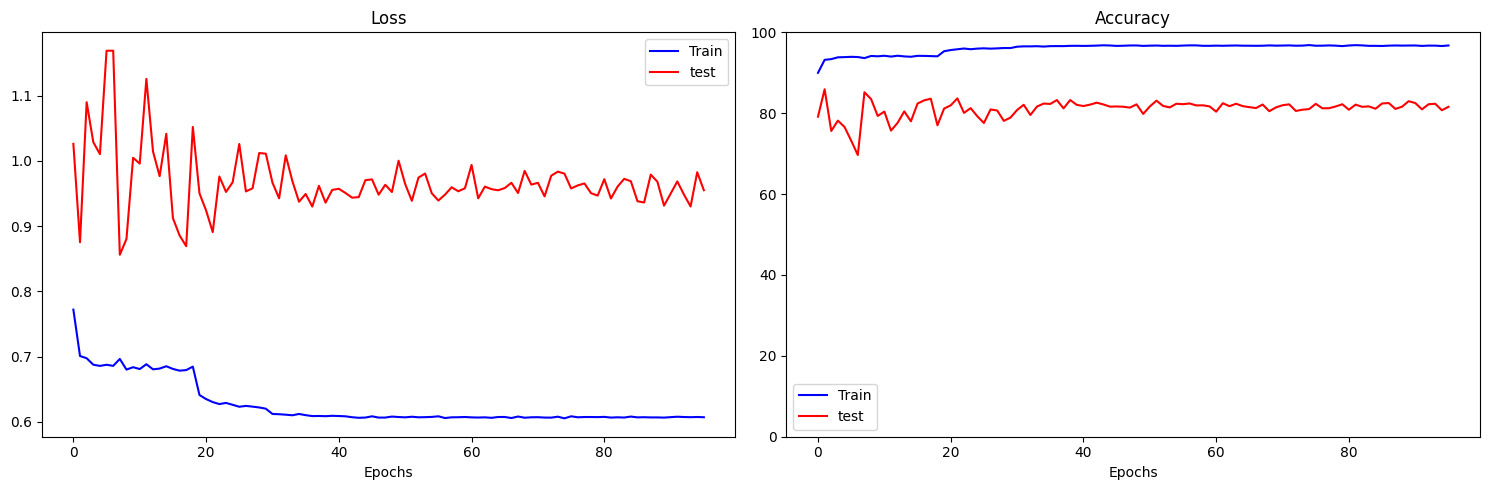

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(121)   #Loss
plt.plot(train_loss, label='Train', color = 'blue')
plt.plot( test_loss, label='test', color = 'red')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.title('Loss')
plt.subplot(122)  #Accuracy 
plt.plot(train_accuracy, label='Train', color = 'blue')
plt.plot(test_accuracy, label='test', color = 'red')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.ylim([0,100])
plt.tight_layout()
plt.savefig(f'results/loss_accuracy_graphs_{prefix}.jpeg')
plt.show()

In [18]:
def Eval(data_loader, model):
    model.eval()
    y_true = torch.zeros(0, dtype=torch.long, device='cpu')
    y_preds = torch.zeros(0, dtype=torch.long, device='cpu')
    with torch.no_grad():
        for data, targets in tqdm(data_loader):   
            data = data.cuda()
            targets = targets.cuda()
            scores = model(data)
            preds = torch.softmax(scores, dim=1).argmax(dim=1).detach() 
            y_true = torch.cat([y_true, targets.view(-1).cpu()])
            y_preds = torch.cat([y_preds, preds.view(-1).cpu()])
            del data, targets, scores, preds
    return y_true, y_preds

def get_results(y_true_test, y_preds_test, base):
    results=pd.DataFrame(index=np.arange(1), columns=['Set', 'Accuracy', 'Balanced Accuracy', 'F1 Score', 'Precision', 'Recall'])
    i=0
    for (true,pred) in [(y_true_test,  y_preds_test)]:
        a=accuracy_score(true,pred,)
        p=precision_score(true,pred,average='macro')
        r=recall_score(true,pred,average='macro')
        f1=f1_score(true,pred,average='macro')
        ba=balanced_accuracy_score(true,pred)
        results.iloc[i]=[base[i],a, ba, f1,p,r]
        i+=1
    return results

In [19]:
y_true_train ,y_preds_train = Eval(train_loader, model)
y_true_test ,y_preds_test = Eval(test_loader, model)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [01:14<00:00,  2.08s/it]


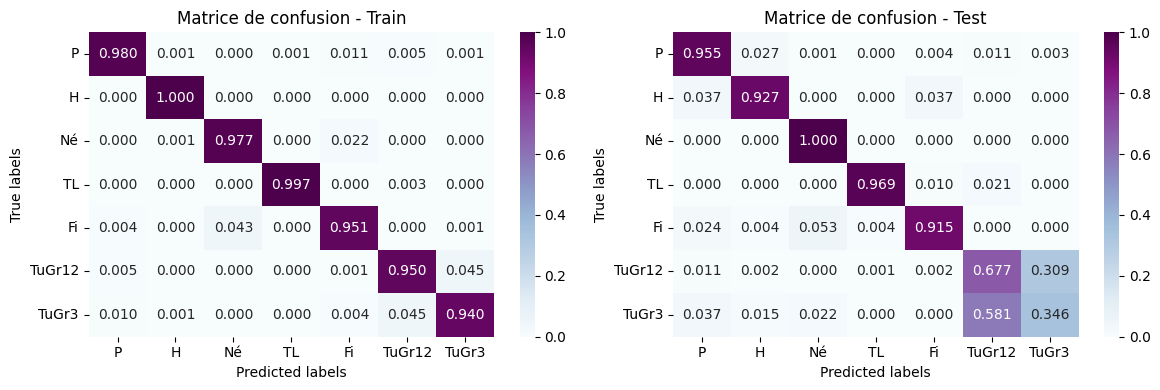

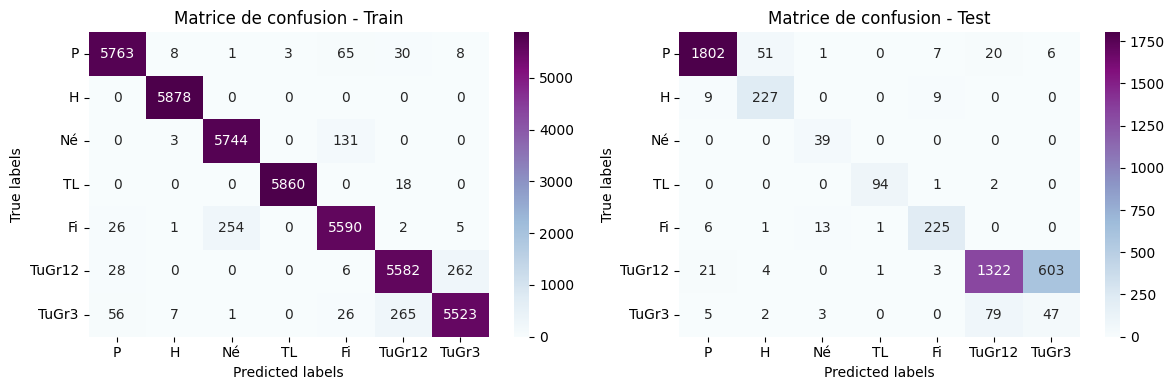

In [20]:
idx_to_label = {'P':0, 'H':1, 'Né':2, 'TL':3, 'Fi':4, 'TuGr12':5, 'TuGr3':6}
labels =  list(idx_to_label.keys())

conf_mat_test = confusion_matrix(y_true_test.numpy() ,y_preds_test.numpy(), normalize='true') 
conf_mat_train = confusion_matrix(y_true_train.numpy() ,y_preds_train.numpy(), normalize='true')   

plt.figure(figsize=(12,4))
plt.subplot(121)   #Train
sns.heatmap(conf_mat_train, annot=True, fmt='0.3f',xticklabels=labels,yticklabels=labels, cmap='BuPu') 
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matrice de confusion - Train')
plt.subplot(122)   #Test
sns.heatmap(conf_mat_test, annot=True, fmt='0.3f',xticklabels=labels,yticklabels=labels, cmap='BuPu') 
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matrice de confusion - Test')
plt.tight_layout()
plt.savefig(f'results/confusion_matrix_Normalized_{prefix}.jpeg')
plt.show()

conf_mat_test = confusion_matrix(y_true_test.numpy() ,y_preds_test.numpy()) 
conf_mat_train = confusion_matrix(y_true_train.numpy() ,y_preds_train.numpy())   

plt.figure(figsize=(12,4))
plt.subplot(121)   #Train
sns.heatmap(conf_mat_train, annot=True, fmt='0.0f',xticklabels=labels,yticklabels=labels, cmap='BuPu') 
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matrice de confusion - Train')
plt.subplot(122)   #Test
sns.heatmap(conf_mat_test, annot=True, fmt='0.0f',xticklabels=labels,yticklabels=labels, cmap='BuPu') 
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matrice de confusion - Test')
plt.tight_layout()
plt.savefig(f'results/confusion_matrix_NotNormalized_{prefix}.jpeg')
plt.show()

In [25]:
res_train=get_results(y_true_train ,y_preds_train, base=['Train'])
res_test=get_results(y_true_test ,y_preds_test, base=['Test'])
results = pd.concat([res_train,res_test], ignore_index=True)
results.to_excel('results/results_train_test.xlsx', index=False)
results

ModuleNotFoundError: No module named 'openpyxl'